In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from superres import *

In [2]:
img_data = Path('/scratch/bpho/datasets/emsynth_002//')
model_path = Path('/scratch/bpho/models')

In [3]:
def get_src():
    hr_tifs = img_data/f'hr'
    lr_tifs = img_data/f'lr_up'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src


def get_data(bs, size, noise=None):
    src = get_src()
    tfms = get_transforms(flip_vert=True, max_zoom=2)
    data = (src
            .transform(tfms, size=size)
            .transform_y(tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [4]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [5]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [6]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [7]:
bs = 64
size = 128
data = get_data(bs, size)
data

/scratch/bpho/datasets/emsynth_002/lr_up


ImageDataBunch;

Train: LabelList (1728 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/emsynth_002/lr_up;

Valid: LabelList (432 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /scratch/bpho/datasets/emsynth_002/lr_up;

Test: None

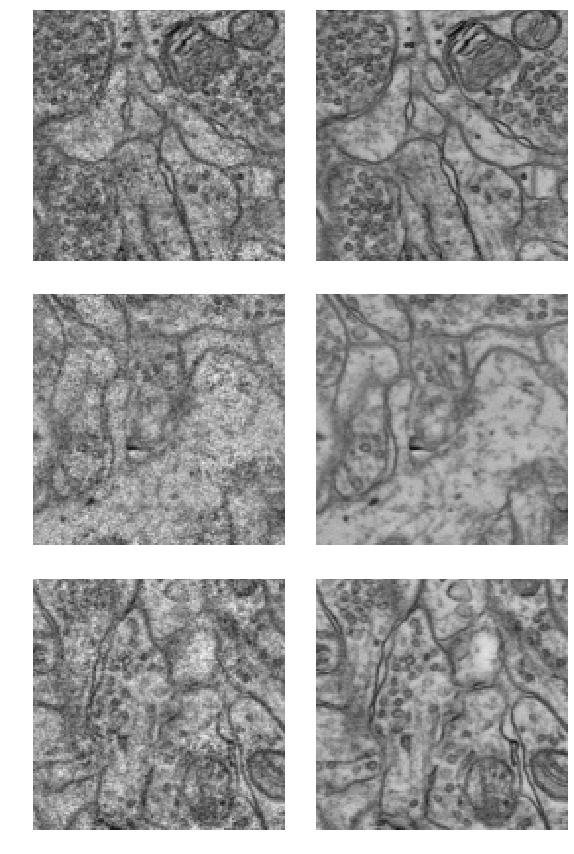

In [8]:
data.show_batch(3, ds_type=DatasetType.Valid)

In [ ]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [9]:
lr = 1e-3

In [10]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [ ]:
do_fit('emsynth_002_unet.0', slice(lr*10))

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_002_unet.1', slice(1e-5,lr))

In [11]:
bs = 32
size = 256
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.1')

/scratch/bpho/datasets/emsynth_002/lr_up


/home/fredmonroe/anaconda3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
do_fit('emsynth_002_unet.2', lr)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.270256,1.163312,0.049884,0.476068,13.021883,0.176271,0.200575,0.203262,0.045648,0.247428,0.260733,0.029396,01:02
1,1.231228,1.156922,0.049048,0.481012,13.095269,0.174459,0.202052,0.205741,0.046176,0.242987,0.256087,0.029420,00:50
2,1.197619,1.134818,0.049239,0.484779,13.078356,0.174540,0.203660,0.206902,0.046292,0.227631,0.246654,0.029137,00:50
3,1.174267,1.104616,0.049241,0.479398,13.078164,0.174995,0.201387,0.205118,0.045887,0.211578,0.236793,0.028857,00:51


In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_002_unet.3', slice(1e-5,lr))

In [ ]:
bs = 4
size = 512
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.3')

In [ ]:
do_fit('emsynth_002_unet.4', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_002_unet.5', slice(1e-5,lr), cycle_len=50)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.5')

In [ ]:
do_fit('emsynth_002_unet.6', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('emsynth_002_unet.7', slice(1e-5,lr), cycle_len=50)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('emsynth_002_unet.6')

In [ ]:
learn.unfreeze()
do_fit('emsynth_002_unet.8', slice(1e-6,1e-5), cycle_len=10)

In [ ]:
!ls /scratch/bpho/models